## Regridding GOES-16 image to IMERG horizontal resolution (0.1 x 0.1 deg)

### Python packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import os
import glob
import re

### Functions

In [3]:
def extract_yyyydoy(fpath):
    """
    Return integer YYYYDOY if found in the basename of fpath; else None.
    """
    fname = os.path.basename(fpath)
    m = doy_pattern.search(fname)
    return int(m.group(1)) if m else None

def extract_hhmm(fpath):
    """
    Return 4-digit HHMM if found (as the group after YYYYDOY); else "0000".
    """
    fname = os.path.basename(fpath)
    m = time_pattern.search(fname)
    return m.group(2) if m else "0000"

def preprocess(ds):
    """
    If 'mc_calibhed_size' appears in ds.dims, drop it;
    otherwise return ds unchanged.
    """
    if 'mc_calibhed_size' in ds.dims:
        return ds.drop_dims('mc_calibhed_size', errors='ignore')
    return ds

### Loading data

In [4]:
# Time range
start_doy = 2020015  # 015 January 15, 2020
end_doy   = 2020050  # 050 February 19, 2020

# Base directory
base_dir = '/home/huangany/data/KloudatA/GOES-16/2020'

# Output directory
output_dir = os.path.join(base_dir, 'regrid') # Full domain
#output_dir = os.path.join(base_dir, 'rfv_bin_NW') # NW domain
#output_dir = os.path.join(base_dir, 'rfv_bin_NE') # NE domain
os.makedirs(output_dir, exist_ok=True)

# Regex to extract the 7-digit YYYYDOY and 4-digit HHMM from each filename
doy_pattern  = re.compile(r'(\d{7})\.\d{4}')
time_pattern = re.compile(r'\.(\d{7})\.(\d{4})\.')

In [5]:
# Gather & filter all .NC files by DOY range
all_files = sorted(glob.glob(os.path.join(base_dir, '01', '**', '*.NC'), recursive=True)
                  + glob.glob(os.path.join(base_dir, '02', '**', '*.NC'), recursive=True))
filtered_files = [
    f for f in all_files
    if (extract_yyyydoy(f) is not None) and (start_doy <= extract_yyyydoy(f) <= end_doy)
]

# Define box limits (longitude and latitude): ATOMIC Field Campaign region
# Regrid to IMERG grids
lon_min, lon_max = -60.05, -48.95
lat_min, lat_max = 12.45, 16.05
res = 0.1

# Convert to edges for grid_2d:
lon0_edge = lon_min - res/2   # -60.10
lon1_edge = lon_max + res/2   # -48.90
lat0_edge = lat_min - res/2   #  12.40
lat1_edge = lat_max + res/2   #  16.10

### Loop over each filtered file and compute & save

In [13]:
for file_path in filtered_files:
    # a) Extract YYYYDOY and HHMM for filenames & summary
    yyyydoy = extract_yyyydoy(file_path)
    hhmm    = extract_hhmm(file_path)

    # b) Open the dataset and drop unwanted dims if present
    ds = xr.open_dataset(file_path)
    ds = preprocess(ds)
    
    # c) Compute full-domain average solar zenith angle (SZA)
    # Make sure we are using day-time data
    sza = ds['solar_zenith_angle'].values    # shape: (ny, nx)
    avg_sza = float(np.nanmean(sza))          # scalar

    if avg_sza > 90.0:
        ds.close()
        continue
    else:
        print(file_path)
    
    # d) Build an xarray Dataset for regridding
    dsn = ds.rename({"longitude": "lon", "latitude": "lat"})
    ds_regrid = xe.util.grid_2d(lon0_edge, lon1_edge, res, lat0_edge, lat1_edge, res)
    regridder = xe.Regridder(dsn, ds_regrid, "bilinear")

    # e) Build region mask (X<901, Y<901) once, since needed for valid_fraction either way
    cth = ds['cloud_top_height'].values      # shape: (ny, nx)
    # cth_zerofilled = np.where(np.isnan(cth), 0, cth)
    
    # cth_out = regridder(cth_zerofilled)
    cth_out = regridder(cth, skipna=True, na_thres=0.5)
    
    # f) Build an xarray Dataset to save out to NetCDF
    ds_out = xr.Dataset(
        data_vars={
            "cloud_top_height": (
                ("latitude", "longitude"),
                cth_out,
                {
                    "long_name": "Cloud-top height",
                    "units": "km",
                    "_FillValue": np.nan
                },
            ),
        },
        coords={
            "longitude": np.arange(lon_min, lon_max+res, res),
            "latitude": np.arange(lat_min, lat_max, res),
        },
        attrs={
            "source_file": os.path.basename(file_path),
            "YYYYDOY":     str(yyyydoy),
            "HHMM":        hhmm
        }
    )
    
    # g) Save the Dataset to a NetCDF file named by YYYYDOY_HHMM
    original_name = os.path.basename(file_path)
    output_name = original_name.replace(".NC", ".0.1RES.NC")
    out_fname = os.path.join(output_dir, output_name)
    ds_out.to_netcdf(out_fname)

    # i) Close both Datasets before moving on
    ds_out.close()
    ds.close()
    dsn.close()

/home/huangany/data/KloudatA/GOES-16/2020/02/19/G16V04.0.ATOMIC.2020050.1720.PX.02K.NC


/tmp/ipykernel_2974270/3916301245.py:4: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()
/tmp/ipykernel_2974270/3916301245.py:12: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(ds.longitude, ds.latitude, cth, vmin=0, vmax=17.5)
/tmp/ipykernel_2974270/3916301245.py:13: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


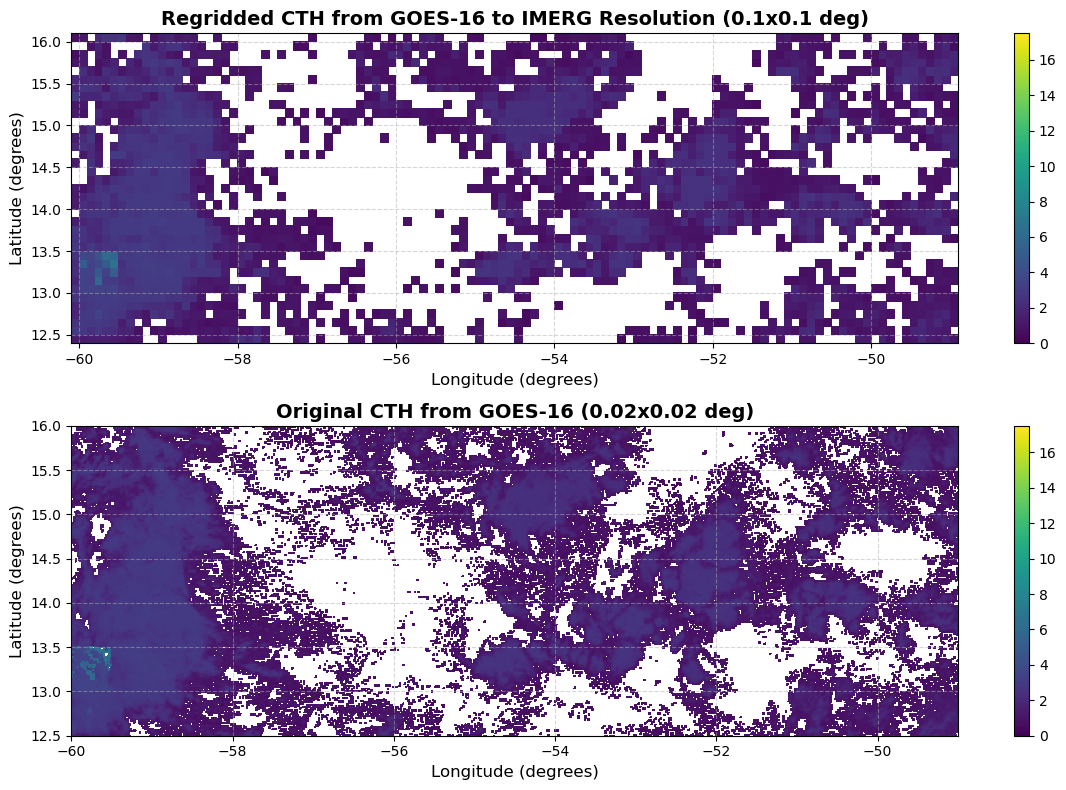

In [14]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.pcolor(ds_out.longitude, ds_out.latitude, cth_out, vmin=0, vmax=17.5)
plt.colorbar()
plt.grid(linestyle='--', alpha=0.5)
plt.title(f'Regridded CTH from GOES-16 to IMERG Resolution (0.1x0.1 deg)', fontsize=14, fontweight='bold')
plt.xlabel('Longitude (degrees)', fontsize=12)
plt.ylabel('Latitude (degrees)', fontsize=12)

plt.subplot(2,1,2)
# plt.pcolor(ds.longitude, ds.latitude, cth_zerofilled, vmin=0, vmax=17.5)
plt.pcolor(ds.longitude, ds.latitude, cth, vmin=0, vmax=17.5)
plt.colorbar()
plt.grid(linestyle='--', alpha=0.5)
plt.title(f'Original CTH from GOES-16 (0.02x0.02 deg)', fontsize=14, fontweight='bold')
plt.xlabel('Longitude (degrees)', fontsize=12)
plt.ylabel('Latitude (degrees)', fontsize=12)
plt.xlim(-60, -49)
plt.ylim(12.5, 16)

plt.tight_layout()
plt.show()